In [17]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

1. Get the silhouette coefficient of the two-cluster k-means solution. You'll notice that the silhouette coefficient will turn out to be greater than the one above, where the cluster number is three. You know that the iris dataset consists of three different clusters. So the silhouette score of the solution where the number of clusters is equal to the correct number of classes is actually lower than the silhouette score of the solution where the number of clusters is different from the correct number of classes. Can you explain why this is?

In [6]:
# Loading the data from scikit-learn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standardizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [11]:
labels=KMeans(n_clusters=2).fit_predict(X_std)
metrics.silhouette_score(X_std,labels,metric='euclidean')

0.5817500491982808

In [12]:
labels=KMeans(n_clusters=4).fit_predict(X_std)
metrics.silhouette_score(X_std,labels,metric='euclidean')

0.38517417630641415

2. In this assignment, you'll continue working with the heart disease dataset from the UC Irvine Machine Learning Repository. If y is equal to 1, that indicates that the corresponding patient has heart disease. And if y is equal to 0, then the patient doesn't have heart disease.

In [13]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from heartdisease',con=engine)

# No need for an open connection, 
# because you're only doing a single query
engine.dispose()

In [32]:
 # Define the features and the outcome
 X =df.iloc[:, :13]
 y = df.iloc[:, 13]

 # Replace missing values (marked by `?`) with a `0`
 X = X.replace(to_replace='?', value=0)
X=X.iloc[:-1,:]
 # Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
 y = np.where(y > 0, 1, 0)
X.shape

(302, 13)

1. Split the data randomly into two. Apply k-means using two, three, and four as the number of clusters, as you did when you were exploring consistency earlier in this checkpoint. Assess the consistency of the solutions using visualization. Which one seems to be the best?

In [33]:
# Standardizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X_std)

# Splitting the data into four equally sized samples. First, break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=1)

In [37]:
# DataFrame to store features and predicted cluster memberships
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time that you go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. You use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the DataFrame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into `ypred`
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2-4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

In [34]:
X_half1.shape, X_pcahalf1.shape

((151, 13), (151, 2))

In [35]:
X_half2.shape, X_pcahalf2.shape

((151, 13), (151, 2))

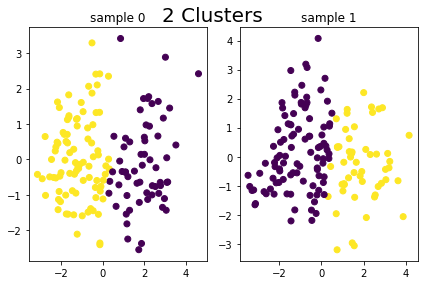

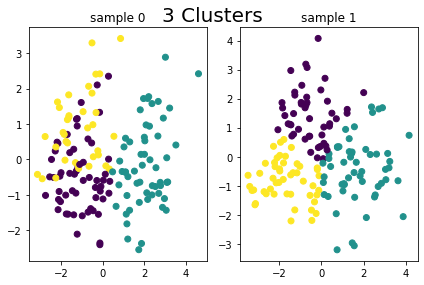

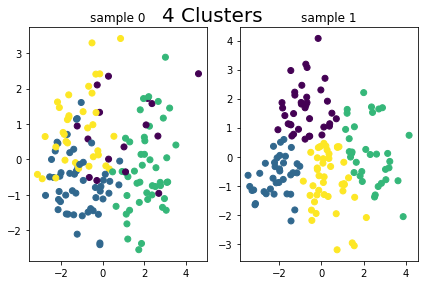

In [38]:
# For each  number of clusters, plot the clusters using the
# PCA features for each sample
for cluster in range(2, 5):
    
    # Make a grid of subplots
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample
    for i in range(2):
        
        # PCA-created features
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

the four-cluster solution isn't consistent across the subsamples.

2. Apply k-means on the whole dataset by setting k equal to 2, 3, and 4. Get the ARI score for each of them. Which model is best?

In [44]:
# Define the features and the outcome
X =df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by `?`) with a `0`
X = X.replace(to_replace='?', value=0)
# Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
y = np.where(y > 0, 1, 0)

In [45]:
X_std=StandardScaler().fit_transform(X)

In [51]:
for i in range (2,5):
    pred=KMeans(n_clusters=i,random_state=1).fit_predict(X_std)
    print('ARI k={} : {}'.format(i,metrics.adjusted_rand_score(y,pred)))

ARI k=2 : 0.4380857727169879
ARI k=3 : 0.2786759157294936
ARI k=4 : 0.20220684434268418


3. Apply k-means on the whole dataset by setting k equal to 2, 3, and 4. Get the silhouette coefficient for each of them. Which model is best?

In [53]:
for i in range(2,5):
    label=KMeans(n_clusters=i,random_state=1).fit_predict(X_std)
    print('silhouette coefficient k={} : {}'.format(i,metrics.silhouette_score(X_std,label,metric='euclidean')))


silhouette coefficient k=2 : 0.17530682286260937
silhouette coefficient k=3 : 0.12994598335020285
silhouette coefficient k=4 : 0.13233686032380285


The best solution is the 2 cluster  as its silhouette score is the highest.